# ndaugment

ndaugment is a toolbox for n-dimensional data augmentation. The syntax is inspired by the [imgaug toolbox](https://github.com/aleju/imgaug).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import SimpleITK as sitk

import ndaugment.core as ndc
import ndaugment.operations as ndo

# 2D checkers example

First, we create some example data.

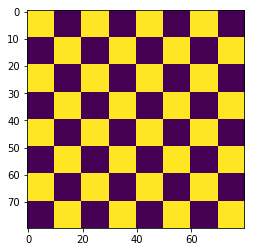

In [2]:
im = np.kron([[1, 0] * 4, [0, 1] * 4] * 4, np.ones((10, 10)))
plt.imshow(im)

Below is a simple example of the ```Sequential``` class, which is the object that will describe all augmentations.

In [3]:
augmenter_2d = ndc.Sequential([
    ndo.ElasticTransform(alpha=(0, 50), sigma=(3, 5), mode='reflect'),  # alpha is chosen randomly between 0 and 50
                                                                        # while sigma is chosen between 3 and 5
    ndo.Rotate(angle=(-45, 45), axes=(0, 1), mode='reflect')
])

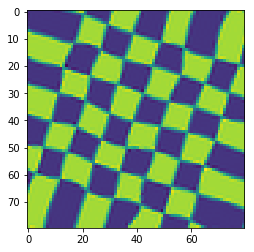

In [4]:
im_aug = augmenter_2d.apply(im)
plt.imshow(im_aug)

To always generate the same image output, you can use the ```random_seed``` argument. This can be useful if you, for example, have a 3D image, and you want to apply the same 2D transformation to every slice.

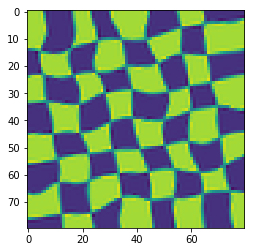

In [5]:
im_aug = augmenter_2d.apply(im, random_seed=42)
plt.imshow(im_aug)

# 3D checkers example 

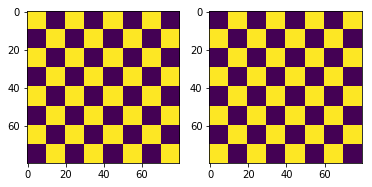

In [6]:
im = np.kron([[[1, 0] * 4, [0, 1] * 4] * 4, [[0, 1] * 4, [1, 0] * 4] * 4], np.ones((10, 10, 10)))

plt.subplot(121)
plt.imshow(im[0])
plt.subplot(122)
plt.imshow(im[10])

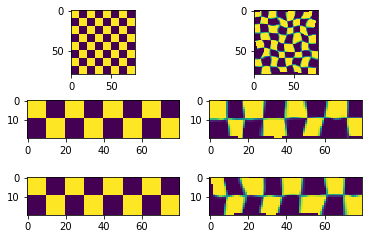

In [7]:
augmenter_3d = ndc.Sequential([
    # alpha and sigma will be the same for each axis
    ndo.ElasticTransform(alpha=(20, 20), sigma=(5, 5), mode='reflect'),  
    
    # alpha will be different from the in the first axis, the same is done with sigma.
    ndo.ElasticTransform(alpha=((10, 10), (150, 150), (150, 150)), sigma=((2, 2), (5, 5), (5, 5))),  
])

im_aug = augmenter_3d.apply(im, random_seed=42)

plt.subplot(321)
plt.imshow(im[5, :, :])
plt.subplot(322)
plt.imshow(im_aug[5, :, :])

plt.subplot(323)
plt.imshow(im[:, 5, :])
plt.subplot(324)
plt.imshow(im_aug[:, 5, :])

plt.subplot(325)
plt.imshow(im[:, :, 5])
plt.subplot(326)
plt.imshow(im_aug[:, :, 5])

Multiple augmentations can be applied as follows. The ```verbose``` argument can be 0 (no verbosity) or 1 (to show progress bar).

                                       ████████████████████████████████████████


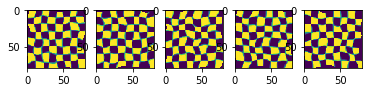

In [8]:
im_aug10 = augmenter_3d.apply_multiple([im] * 10, random_seed=42, verbose=1)

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(im_aug10[i][5])

# 3D MR data

Load in some 3D data with segmentations.

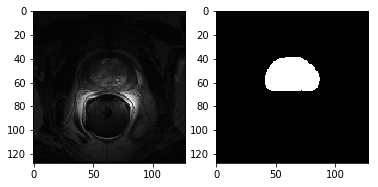

In [9]:
im = sitk.GetArrayFromImage(sitk.ReadImage('images/Case00.nii.gz'))
seg = sitk.GetArrayFromImage(sitk.ReadImage('images/Case00_segmentation.nii.gz'))

plt.subplot(121)
plt.imshow(im[32], cmap='Greys_r')
plt.subplot(122)
plt.imshow(seg[32], cmap='Greys_r')

In the next augmenter, we will implement most of ndaugment's functionality.

In [10]:
extensive_augmenter = ndc.Sequential([
    # zooming, values < 1.0 zoom out, 1.0 will result in no change, > 1.0 will result in zoom in
    ndo.Zoom(val=(.8, 1.2)),  
    
    # shearing with a certain rate, axes specifies along which axis shearing is performed
    ndo.Shear(shear_rate=(-.1, .1), axes=(0, 1)),  
    
    # elastic transformation
    ndo.ElasticTransform(alpha=((2, 2), (20, 20), (20, 20)), sigma=(3, 3), mode='reflect'),
    
    # crop randomly in the image
    ndo.Crop(crop_size=(20, 120, 120)),  
    
    # rotation, axes along which is rotated can be specified
    ndo.Rotate(angle=(-20, 20), axes=(0, 1), mode='reflect'),  
    
    # contrast enhancement/dehancement
    ndo.ChangeContrast(power=(.5, 1.5)),  
    
    # translation
    ndo.Translate(translation_size=((0, 0), (-10, 10), (-10, 10))),  
    
    # flipping along certain axis
    ndo.Flip(prob=0.5, axis=2),  
    
    # gaussian blurring
    ndo.GaussianBlur(sigma=(0, .5)),
    
    # sometimes apply an operation, useful for heavy transformations
    ndo.Sometimes(
        .5,  # probability of 50%
        ndo.Rotate((-60, 60), axes=(1, 2))
    ),
    
    # pick one from a list of operations
    ndo.ChooseOne(
        [
            ndo.GaussianBlur(sigma=(0, .5)),
            ndo.ChooseOne(
                [
                    ndo.Flip(prob=0.5, axis=0),
                    ndo.Flip(prob=0.5, axis=1),
                    ndo.Flip(prob=0.5, axis=2),
                ]
            )  # nesting is also possible
        ]
    ),

    # pick a random number of operations
    ndo.ChooseSome(1, 3,  # pick minimum 1 and maximum 3 of these operations
        [
            ndo.GaussianBlur(sigma=(-.2, .5)),
            ndo.Flip(prob=0.5, axis=0), 
            ndo.ChangeContrast(power=(1., 2.)),
        ]
    )
])

In [ ]:
n_aug = 5  # number of augmentations to make

# do n_aug different augmentations on the same image
im_aug = extensive_augmenter.apply_multiple([im] * n_aug, random_seed=42, verbose=1)

# use the same random seed to get a corresponding mask. set mask to True, such that filters such as blurring and
# contrast enhancement are not applied
seg_aug = extensive_augmenter.apply_multiple([seg] * n_aug, random_seed=42, verbose=1, mask=True)

plt.figure(figsize=(10, 20))
for i in range(n_aug):
    im_slice = im_aug[i][im_aug[i].shape[0] // 2]  # showing the middle slice of each 3d image
    
    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(im_slice, cmap='Greys_r')
    
    aug_slice = seg_aug[i][seg_aug[i].shape[0] // 2]
    
    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(aug_slice, cmap='Greys_r')

                                       ████████████████████████████████████████
                                       ████████████████████████████████